In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
class CONFIG:
    DATA_DIR = "F:/Data/UPSELL_V4/"
    DATA_PATH = DATA_DIR + "data.csv"
    TARGET_COLUMNS = 'IS_UPSELL_NEXT_3_MONTHS'
    COL_TO_DROP = ['CUSTOMER_CODE', 'RANK_', 'CUSTOMER_CODE_INFO', 'LOAN_WID', 'THANG', 'CREATED_DT', 'LOAN_DPD', 'LAST_DATE', 'FIRST_DATE', 'MIN_DISB_DATE', 'DISBURSE_DATE_WID']
    TRAIN_DF = DATA_DIR + 'train.csv'
    TEST_DF = DATA_DIR+ 'test.csv'
    INFER_DF = DATA_DIR+ 'INFER_UPSELL_DATA_202303310903_infer.csv'

In [4]:
train_df = pd.read_csv(CONFIG.TRAIN_DF)
test_df = pd.read_csv(CONFIG.TEST_DF)

C:\Users\duclh3\AppData\Local\Temp\ipykernel_10616\3361546251.py:1: DtypeWarning: Columns (111) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(CONFIG.TRAIN_DF)


In [5]:
train_df['DATE_TIME'] = pd.to_datetime(train_df['DATE_TIME'])
test_df['DATE_TIME'] = pd.to_datetime(test_df['DATE_TIME'])

In [6]:
train_labels = train_df[CONFIG.TARGET_COLUMNS]
test_labels = test_df[CONFIG.TARGET_COLUMNS]
train_df = train_df.drop([CONFIG.TARGET_COLUMNS],axis=1)
test_df = test_df.drop([CONFIG.TARGET_COLUMNS], axis=1)

In [7]:
null_cols = train_df.isnull().sum()/ train_df.shape[0]*100
null_cols.sort_values(ascending=False)

B_SCORE                 95.158384
SALARY_TYPE_CODE        83.357350
MONTHLY_INCOME_VALUE    76.684019
TIME_TO_CONTRACT_3M     75.601007
A_SCORE                 74.155206
                          ...    
AVG_LTV_3M               0.000000
NO_RETRUCTURE            0.000000
NO_RETRUCTURE_12M        0.000000
NO_RETRUCTURE_9M         0.000000
TIME_TO_DISBURSE         0.000000
Length: 117, dtype: float64

In [8]:
train_df['A_SCORE'].min()

500.0

In [9]:
train_df.dtypes

TIME_TO_DISBURSE                   int64
DATE_TIME                 datetime64[ns]
NEXT_DISBURSE_DATE_WID            object
LOAN_STATUS                        int64
CURENT_LTV                       float64
                               ...      
FACEBOOK                          object
MONTHLY_INCOME_VALUE             float64
SALARY_TYPE_CODE                 float64
GRP_NM                            object
JOB_NM_WCD                        object
Length: 117, dtype: object

In [10]:
train_df['WORKPLACE_CODE']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
709221    NaN
709222    NaN
709223    2.0
709224    2.0
709225    1.0
Name: WORKPLACE_CODE, Length: 709226, dtype: float64

In [11]:
train_df['MAX_CLOSE_DATE']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
709221    NaN
709222    NaN
709223    NaN
709224    NaN
709225    NaN
Name: MAX_CLOSE_DATE, Length: 709226, dtype: object

In [12]:
numerical = [x for x in train_df.columns if train_df[x].dtypes in [np.int64, np.float64] and null_cols[x]<96 and x not in ["CUSTOMER_CODE_2","DATE_TIME", "NEXT_DISBURSE_DATE_WID", "TIME_TO_DISBURSE","PAPER_ID"]]

In [13]:
# categorical  = [x for x in train_df.columns if x not in numerical]

In [14]:
'DAYS_FROM_MAX_DISB' in numerical

True

In [15]:
from lightgbm import LGBMRegressor, LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

In [16]:
categorical_features = ["GENDER","INDUSTRY_NM","GRP_NM", "TRADE_LEAD", "ASSET_TYPE"]

In [17]:
INDUSTRY_NM = ['Vận tải/Kho bãi/Cung ứng',
'Nông/Lâm/Thủy Sản',
'Thương mại /Bán buôn bán lẻ/Sửa chữa',
'Viễn thông/Truyền thông',
'Công nghiệp/Thực phẩm/Cơ khí',
'Dịch vụ Công cộng/Hộ gia đình',
'Nhà hàng/Khách sạn/Du lịch',
'Hộ kinh doanh buôn bán nhỏ',
'Y tế/Sức khỏe',
'Xây dựng/Bất động sản',
'Kinh doanh online',
'Điện nước/Xăng dầu/Khoáng sản',
'Giải trí/Nghệ thuật/Vui chơi',
'Tài chính/Ngân hàng/Bảo hiểm',
'Đơn vị quản lý Nhà nước',
'Đào tạo/giáo dục',
'Chuyên môn/Công nghệ/Khoa học']

GRP_NM = ['5 -> 8 triệu',
          '8 -> 10 triệu',
          '10 -> 15 triệu',
          '25 -> 45 triệu',
          '15 -> 25 triệu',
          '< 5 triệu',
          '> 45 triệu']
TRADE_LEAD = ['Hà Nội 1',
              'Hồ Chí Minh 1',
              'Hồ Chí Minh 2',
              'Hà Nội 2',
              'Đông Bắc Bộ 1',
              'Đông Nam Bộ',
              'Đông Bắc Bộ 2',
              'Tây Bắc Bộ',
              'Bắc Trung Bộ',
              'Tây Nam Bộ 2',
              'Tây Nam Bộ 1',
              'Đồng bằng Bắc Bộ',
              'Trung Bộ',
              'Nam Trung Bộ',
              'Tây Nguyên']
ASSET_TYPE = ['DKXM', 'DKOTO']

In [18]:
def feature_engineering(df: pd.DataFrame = train_df):
    new_df = pd.DataFrame()
    for col in numerical:
        new_df[col] = df[col]
        new_df[col] = new_df[col].fillna(-999)
    new_df["CO_THE_VAY_THEM"] = new_df["CO_THE_VAY_THEM"].apply(lambda x: max(0, x))
    # for col in categorical_features:
    #     new_df[col] = df[col]
    #     new_df[col] = new_df[col].astype('category')
    new_df['isMale'] = df['GENDER'] == "Male"
    new_df['isFemale'] = df['GENDER'] == "Female"
    for c in INDUSTRY_NM:
        new_df[f"INDUSTRY_NM_{c}"] = df["INDUSTRY_NM"] == c
    for c in GRP_NM:
        new_df[f"GRP_NM_{c.replace('<','less than')}"] = df["GRP_NM"] == c
    for c in TRADE_LEAD:
        new_df[f"TRADE_LEAD_{c}"] = df["TRADE_LEAD"] == c
    for c in ASSET_TYPE:
        new_df[f"ASSET_TYPE_{c}"] = df["ASSET_TYPE"] == c
    return new_df

In [19]:
new_train_df = feature_engineering(train_df)
new_test_df = feature_engineering(test_df)

In [20]:
new_train_df.shape

(709226, 142)

#########################
Fold 0
#########################
[0]	validation_0-logloss:0.67362	validation_1-logloss:0.67355
[100]	validation_0-logloss:0.49242	validation_1-logloss:0.49439
[200]	validation_0-logloss:0.47962	validation_1-logloss:0.48549
[300]	validation_0-logloss:0.47139	validation_1-logloss:0.48093
[400]	validation_0-logloss:0.46534	validation_1-logloss:0.47822
[500]	validation_0-logloss:0.46032	validation_1-logloss:0.47632
[600]	validation_0-logloss:0.45590	validation_1-logloss:0.47494
[700]	validation_0-logloss:0.45181	validation_1-logloss:0.47390
[800]	validation_0-logloss:0.44796	validation_1-logloss:0.47312
[900]	validation_0-logloss:0.44453	validation_1-logloss:0.47243
[1000]	validation_0-logloss:0.44107	validation_1-logloss:0.47176
[1100]	validation_0-logloss:0.43776	validation_1-logloss:0.47127
[1200]	validation_0-logloss:0.43464	validation_1-logloss:0.47090
[1300]	validation_0-logloss:0.43179	validation_1-logloss:0.47072
[1400]	validation_0-logloss:0.42902	validat

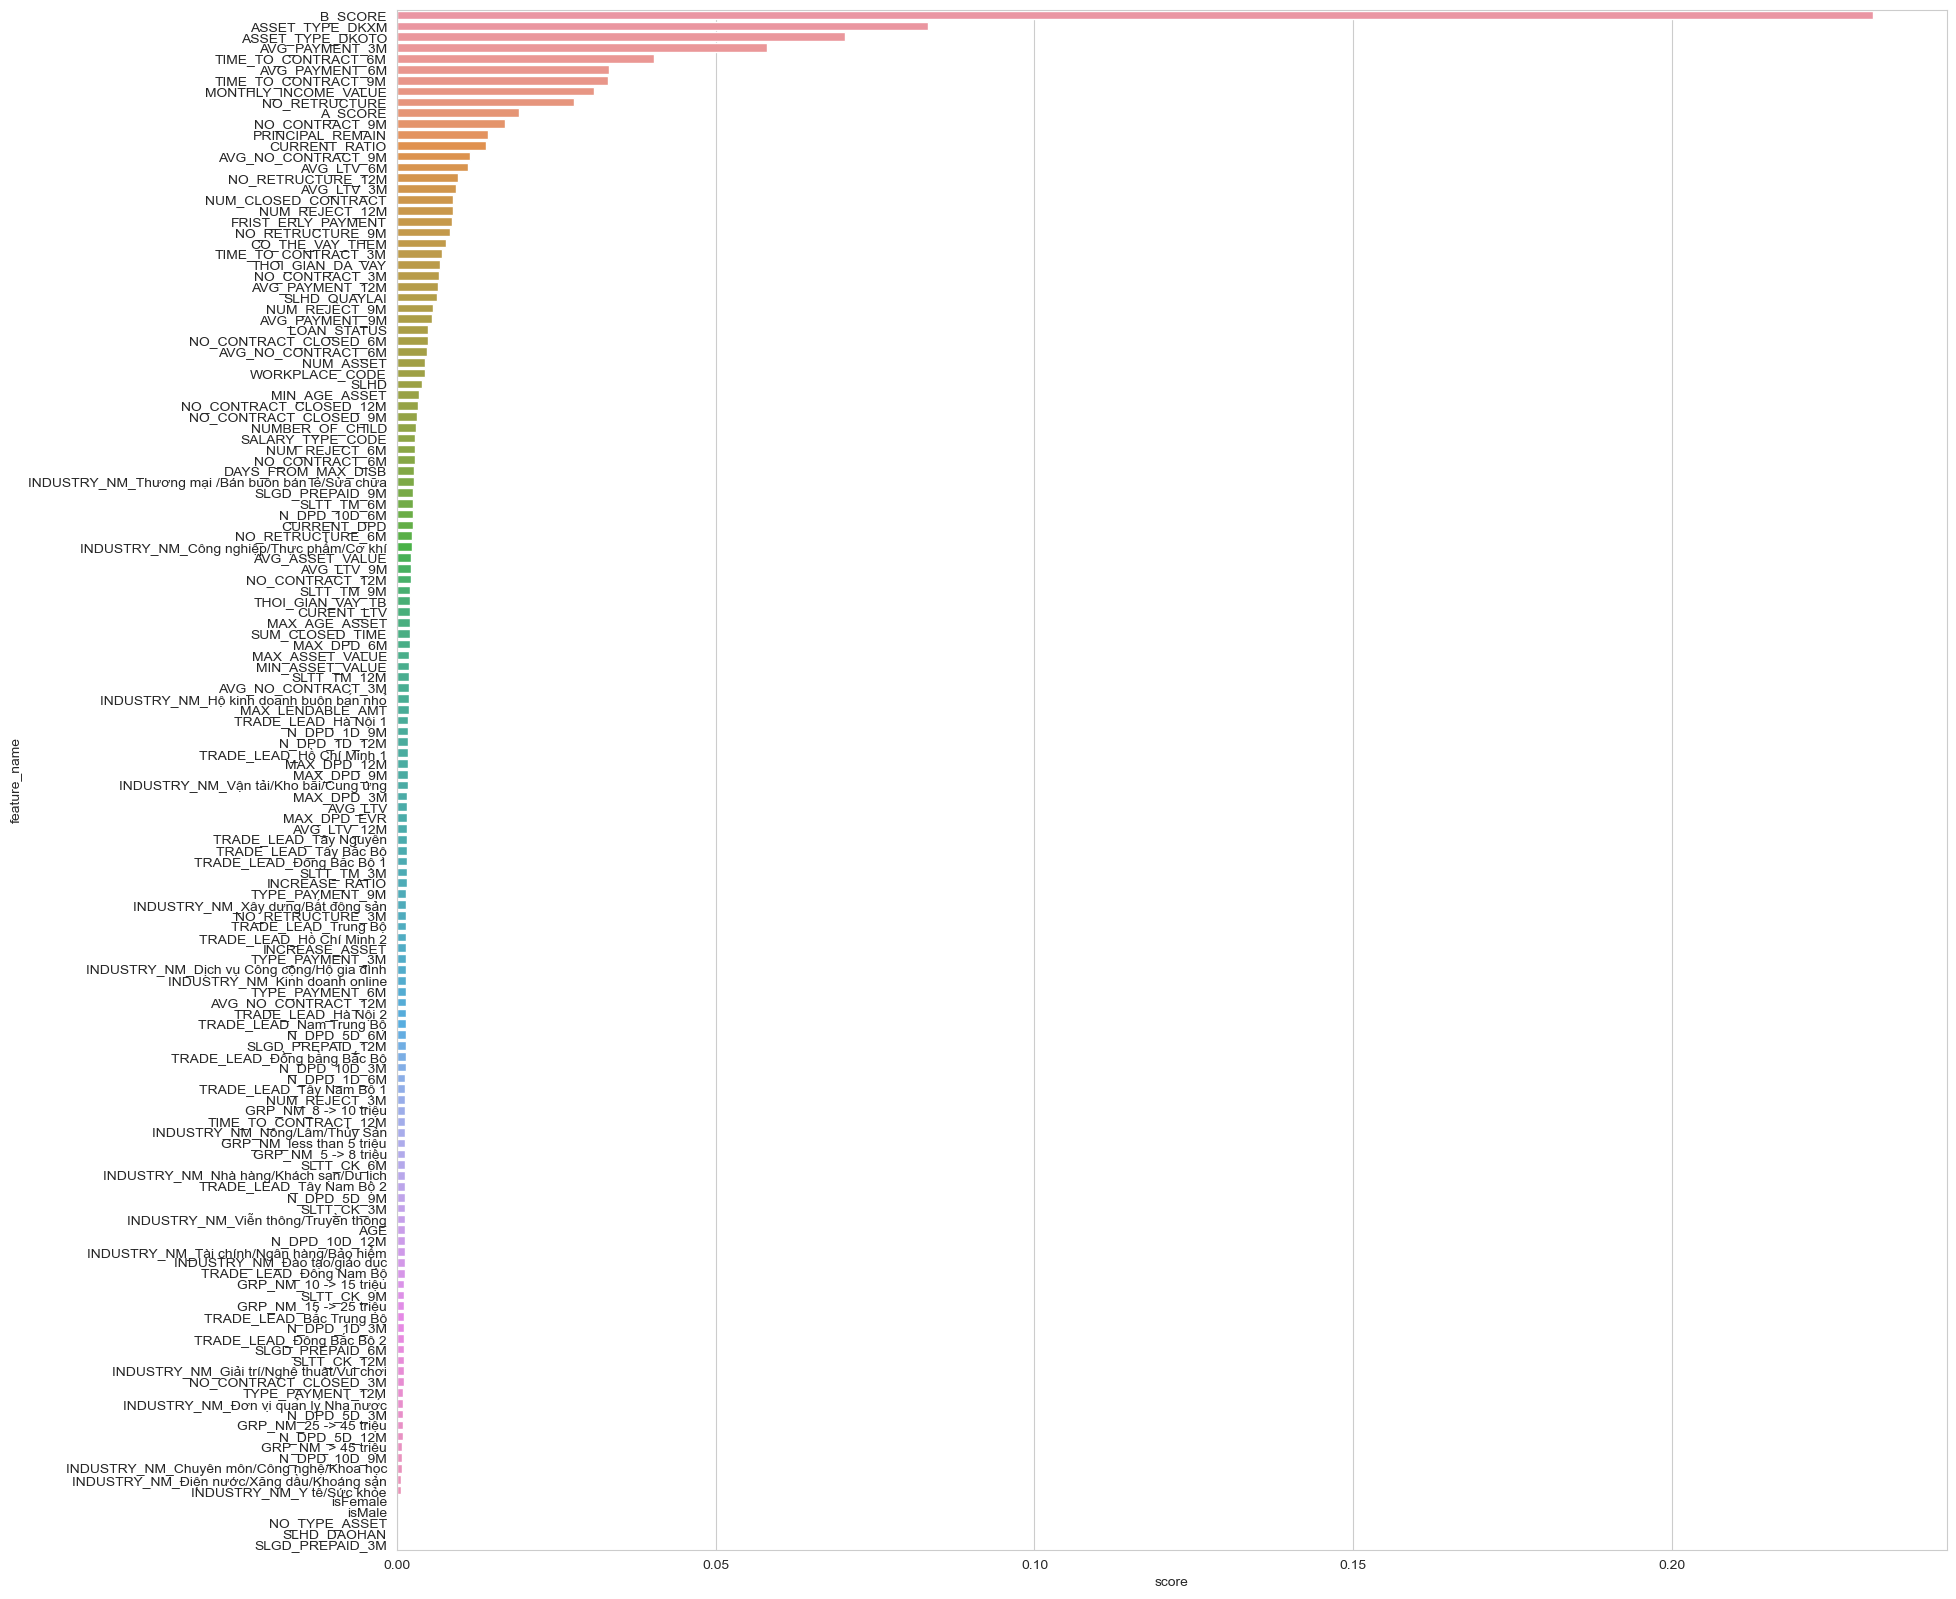

#########################
Fold 1
#########################
[0]	validation_0-logloss:0.67356	validation_1-logloss:0.67368
[100]	validation_0-logloss:0.49182	validation_1-logloss:0.49690
[200]	validation_0-logloss:0.47900	validation_1-logloss:0.48765
[300]	validation_0-logloss:0.47054	validation_1-logloss:0.48263
[400]	validation_0-logloss:0.46458	validation_1-logloss:0.48001
[500]	validation_0-logloss:0.45948	validation_1-logloss:0.47815
[600]	validation_0-logloss:0.45509	validation_1-logloss:0.47694
[700]	validation_0-logloss:0.45089	validation_1-logloss:0.47585
[800]	validation_0-logloss:0.44710	validation_1-logloss:0.47522
[900]	validation_0-logloss:0.44357	validation_1-logloss:0.47479
[1000]	validation_0-logloss:0.44017	validation_1-logloss:0.47425
[1079]	validation_0-logloss:0.43771	validation_1-logloss:0.47413
best iteration 1029
              precision    recall  f1-score   support

           0     0.7545    0.7398    0.7471     67320
           1     0.7690    0.7826    0.7757 

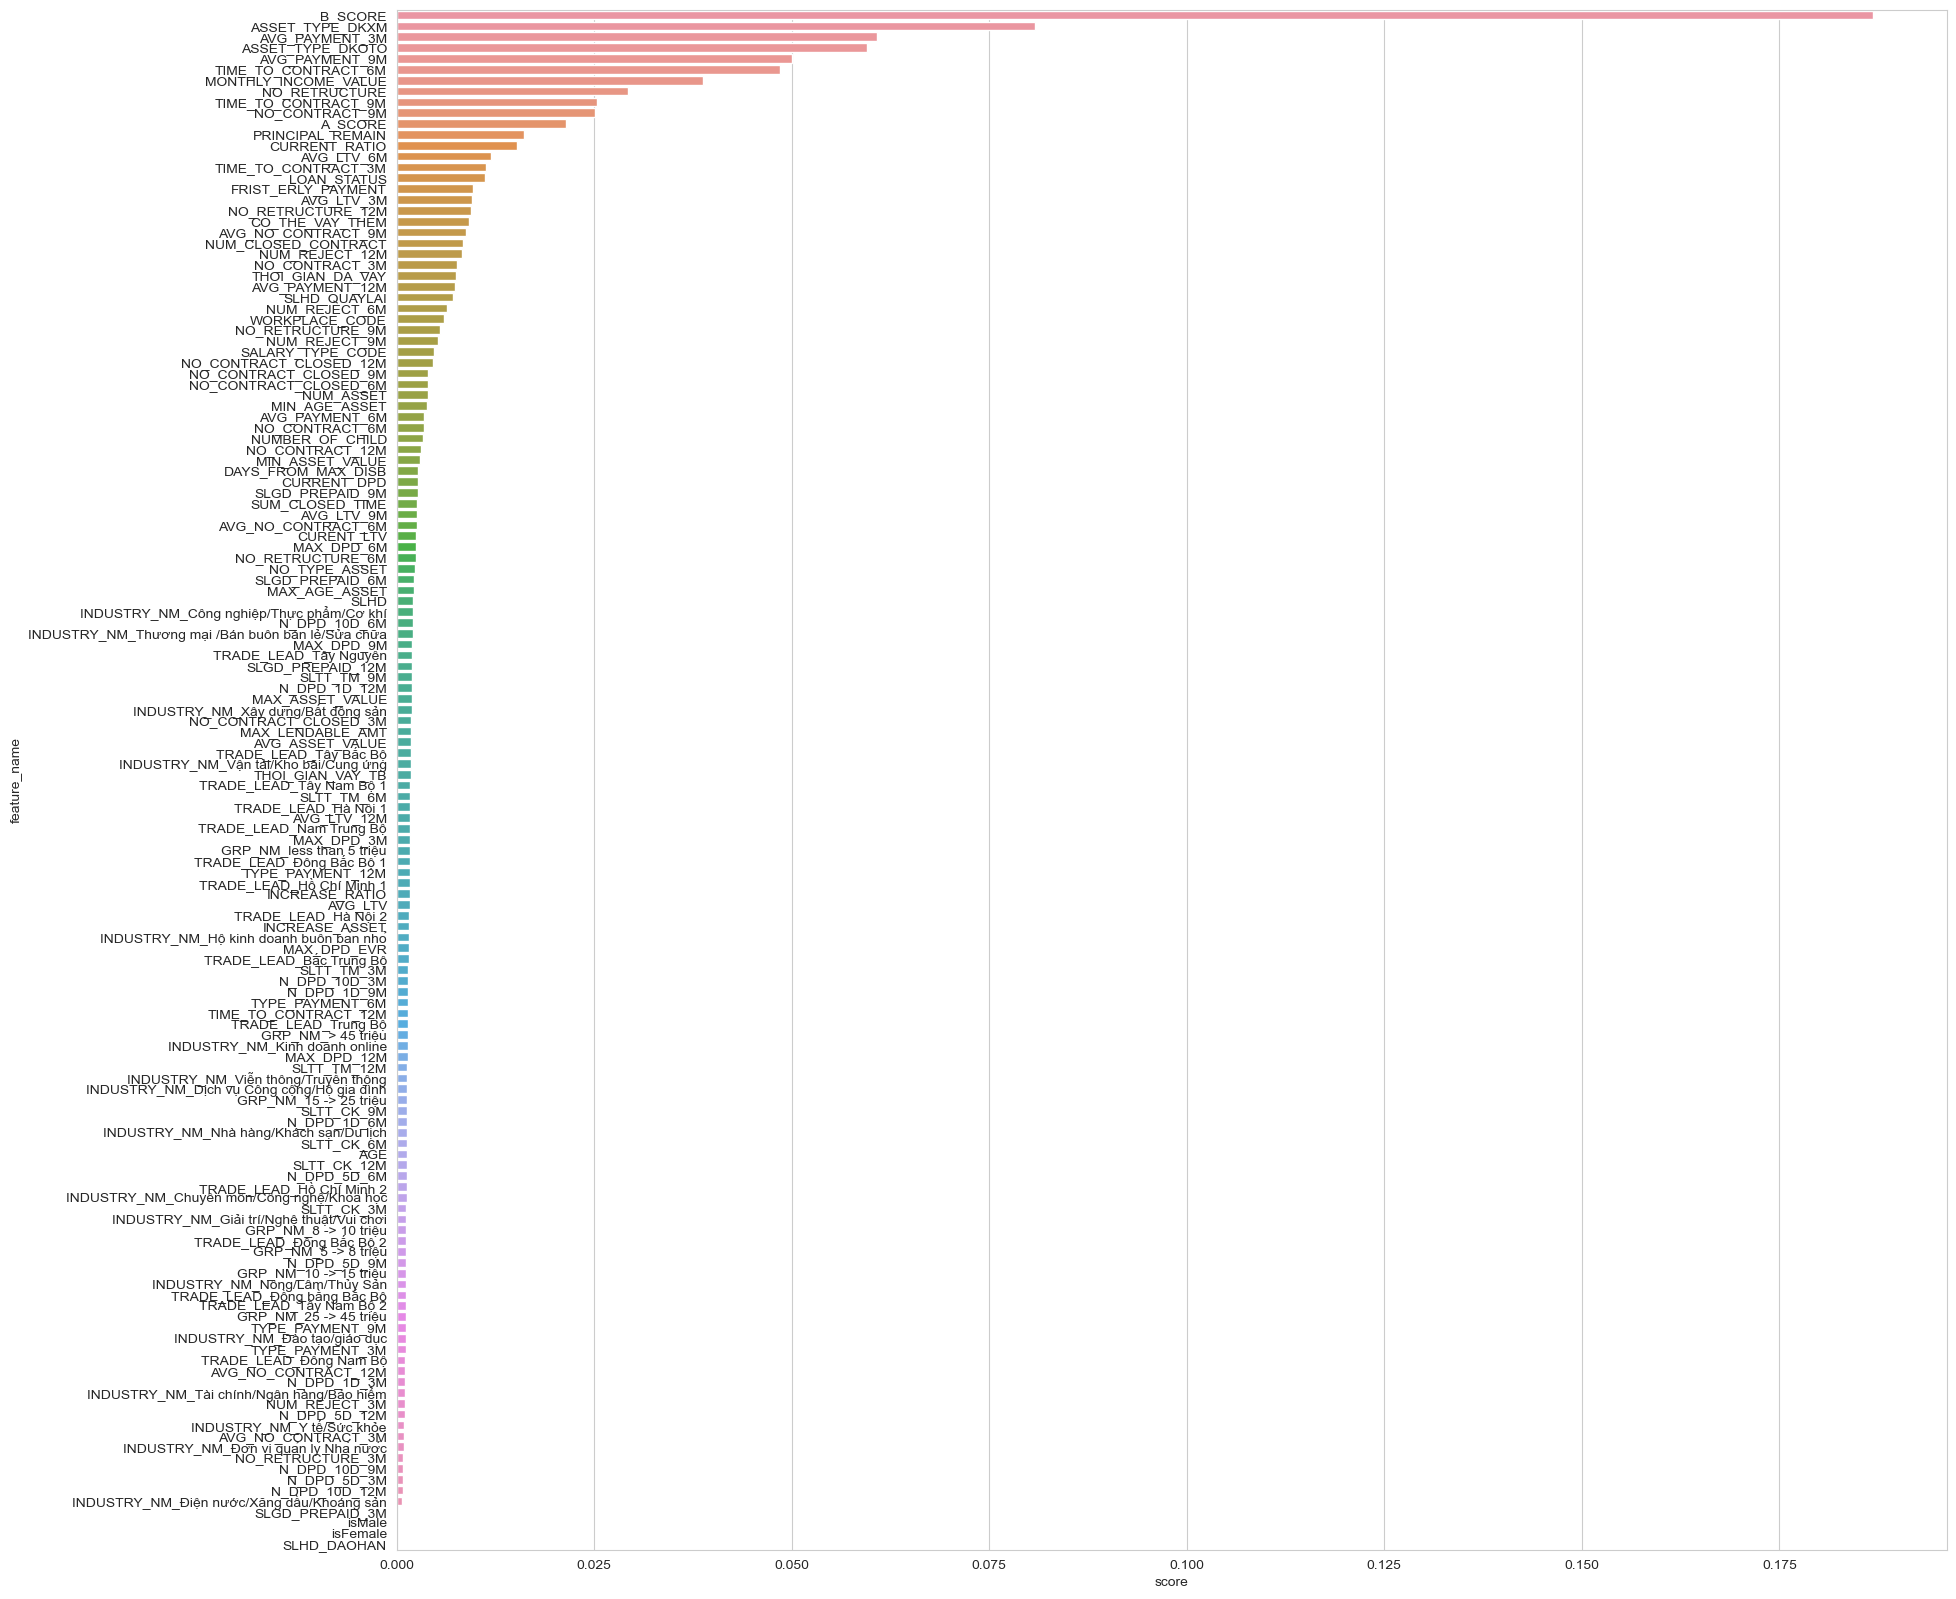

#########################
Fold 2
#########################
[0]	validation_0-logloss:0.67362	validation_1-logloss:0.67360
[100]	validation_0-logloss:0.49200	validation_1-logloss:0.49581
[200]	validation_0-logloss:0.47920	validation_1-logloss:0.48660
[300]	validation_0-logloss:0.47088	validation_1-logloss:0.48179
[400]	validation_0-logloss:0.46482	validation_1-logloss:0.47908
[500]	validation_0-logloss:0.45961	validation_1-logloss:0.47682
[600]	validation_0-logloss:0.45500	validation_1-logloss:0.47533
[700]	validation_0-logloss:0.45097	validation_1-logloss:0.47426
[800]	validation_0-logloss:0.44716	validation_1-logloss:0.47370
[900]	validation_0-logloss:0.44359	validation_1-logloss:0.47299
[1000]	validation_0-logloss:0.44029	validation_1-logloss:0.47259
[1100]	validation_0-logloss:0.43701	validation_1-logloss:0.47216
[1200]	validation_0-logloss:0.43399	validation_1-logloss:0.47192
[1300]	validation_0-logloss:0.43113	validation_1-logloss:0.47174
[1400]	validation_0-logloss:0.42835	validat

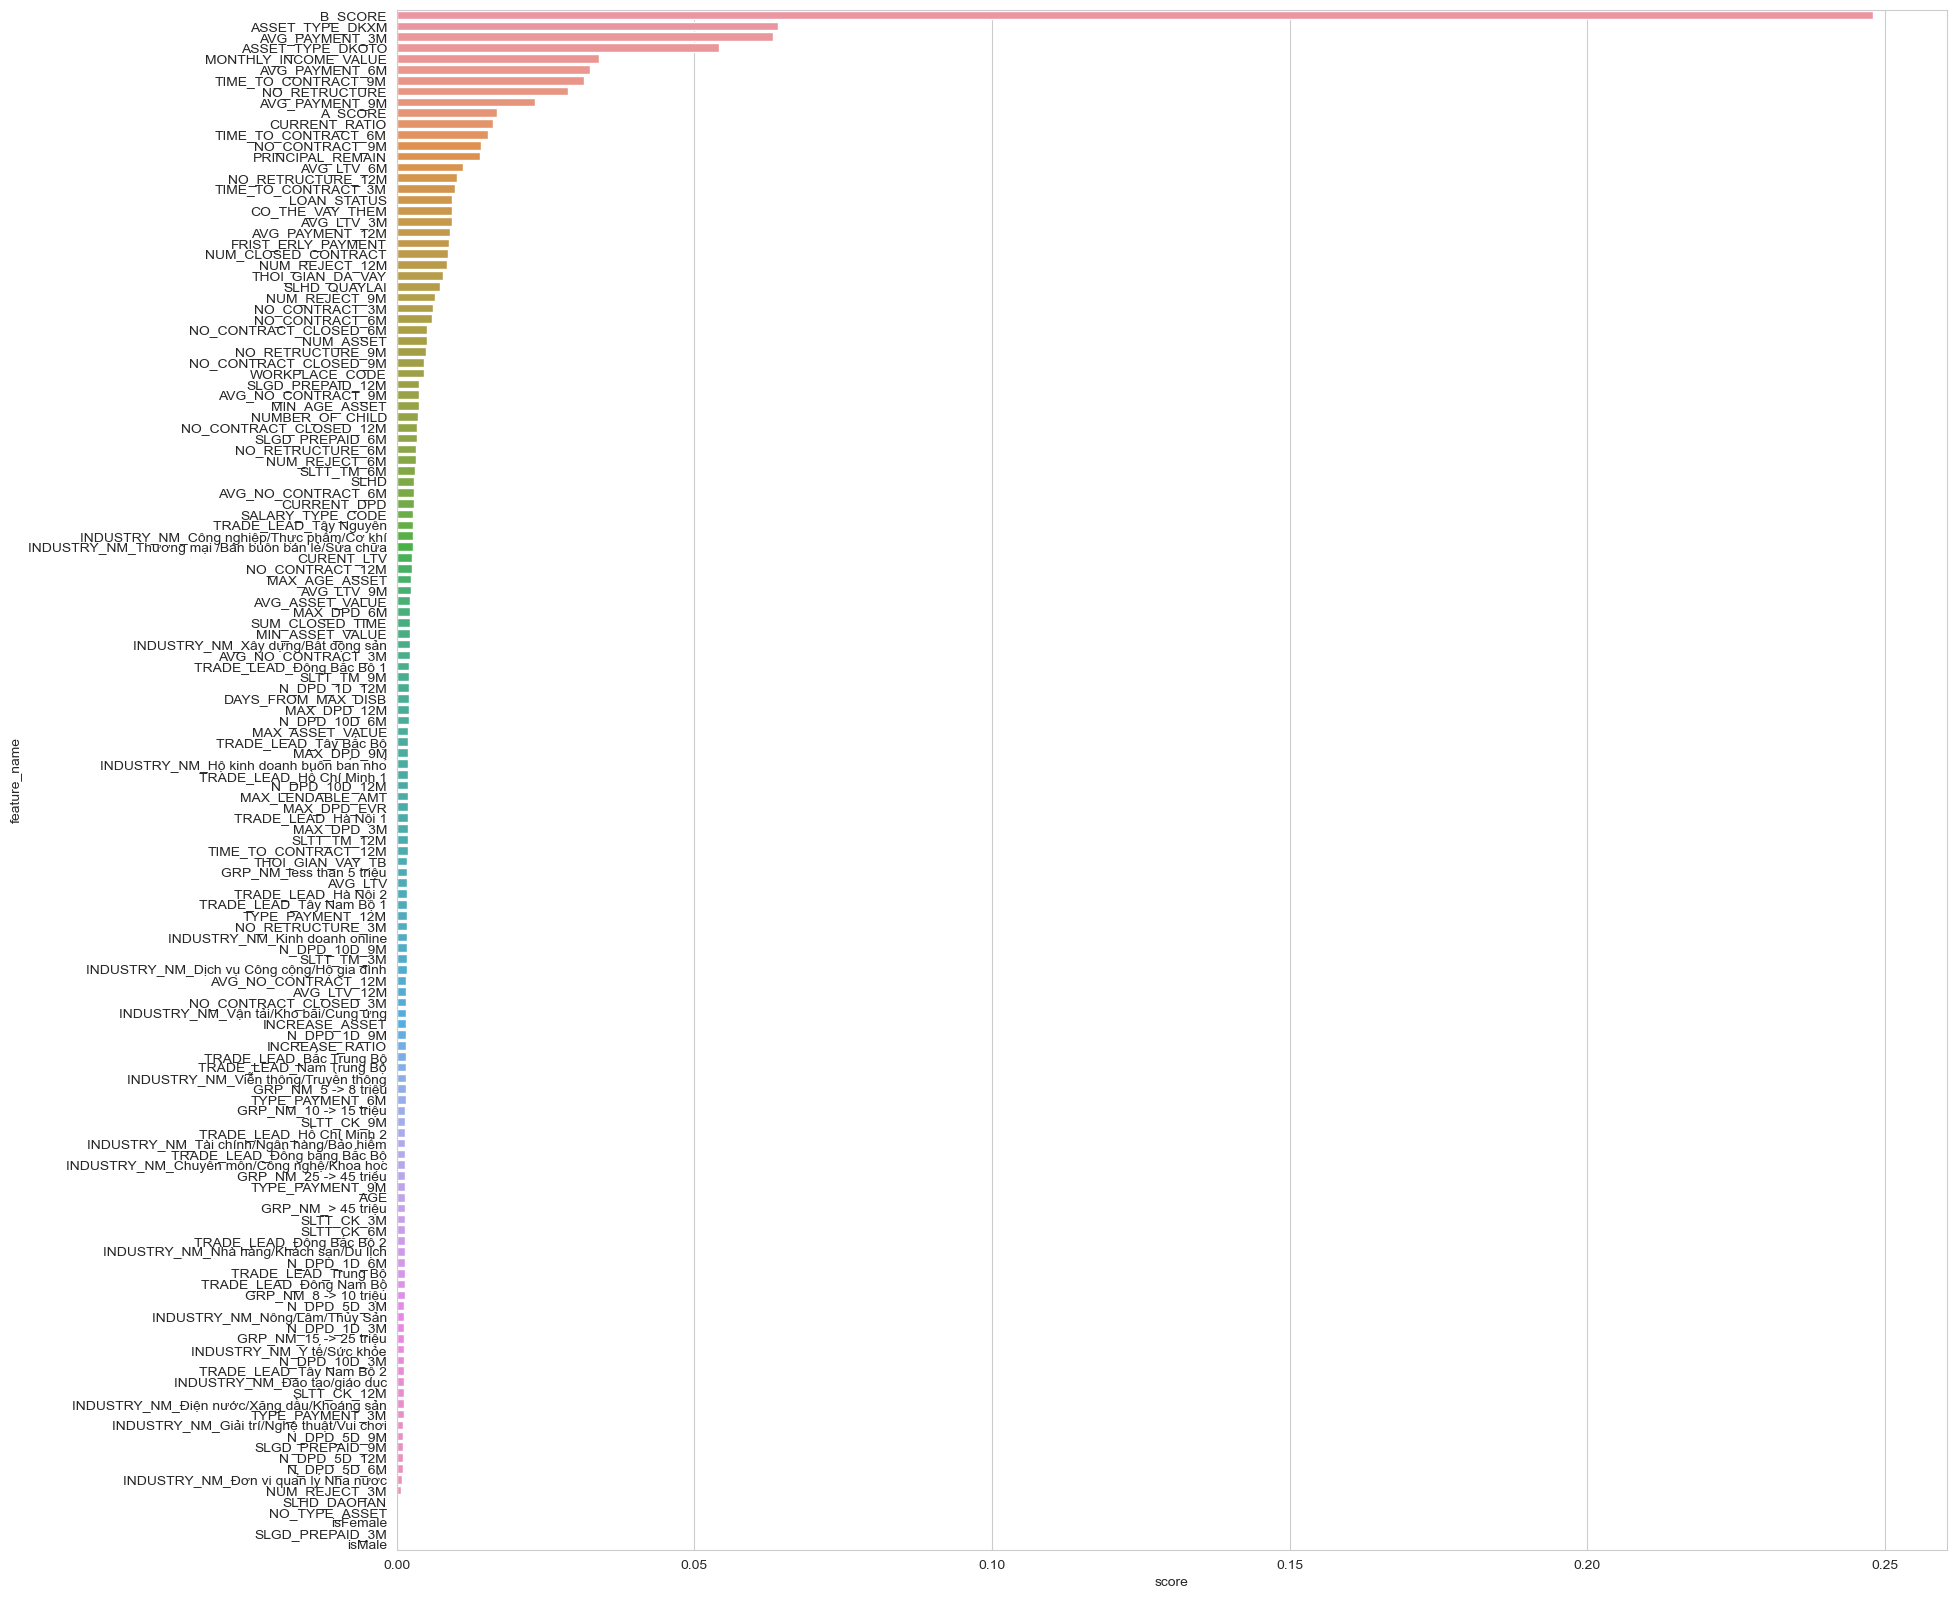

#########################
Fold 3
#########################
[0]	validation_0-logloss:0.67353	validation_1-logloss:0.67352
[100]	validation_0-logloss:0.49262	validation_1-logloss:0.49380
[200]	validation_0-logloss:0.47978	validation_1-logloss:0.48425
[300]	validation_0-logloss:0.47158	validation_1-logloss:0.47957
[400]	validation_0-logloss:0.46512	validation_1-logloss:0.47638
[500]	validation_0-logloss:0.45994	validation_1-logloss:0.47454
[600]	validation_0-logloss:0.45544	validation_1-logloss:0.47317
[700]	validation_0-logloss:0.45128	validation_1-logloss:0.47224
[800]	validation_0-logloss:0.44756	validation_1-logloss:0.47154
[900]	validation_0-logloss:0.44412	validation_1-logloss:0.47101
[1000]	validation_0-logloss:0.44062	validation_1-logloss:0.47045
[1100]	validation_0-logloss:0.43748	validation_1-logloss:0.47022
[1200]	validation_0-logloss:0.43439	validation_1-logloss:0.46988
[1300]	validation_0-logloss:0.43135	validation_1-logloss:0.46976
[1400]	validation_0-logloss:0.42858	validat

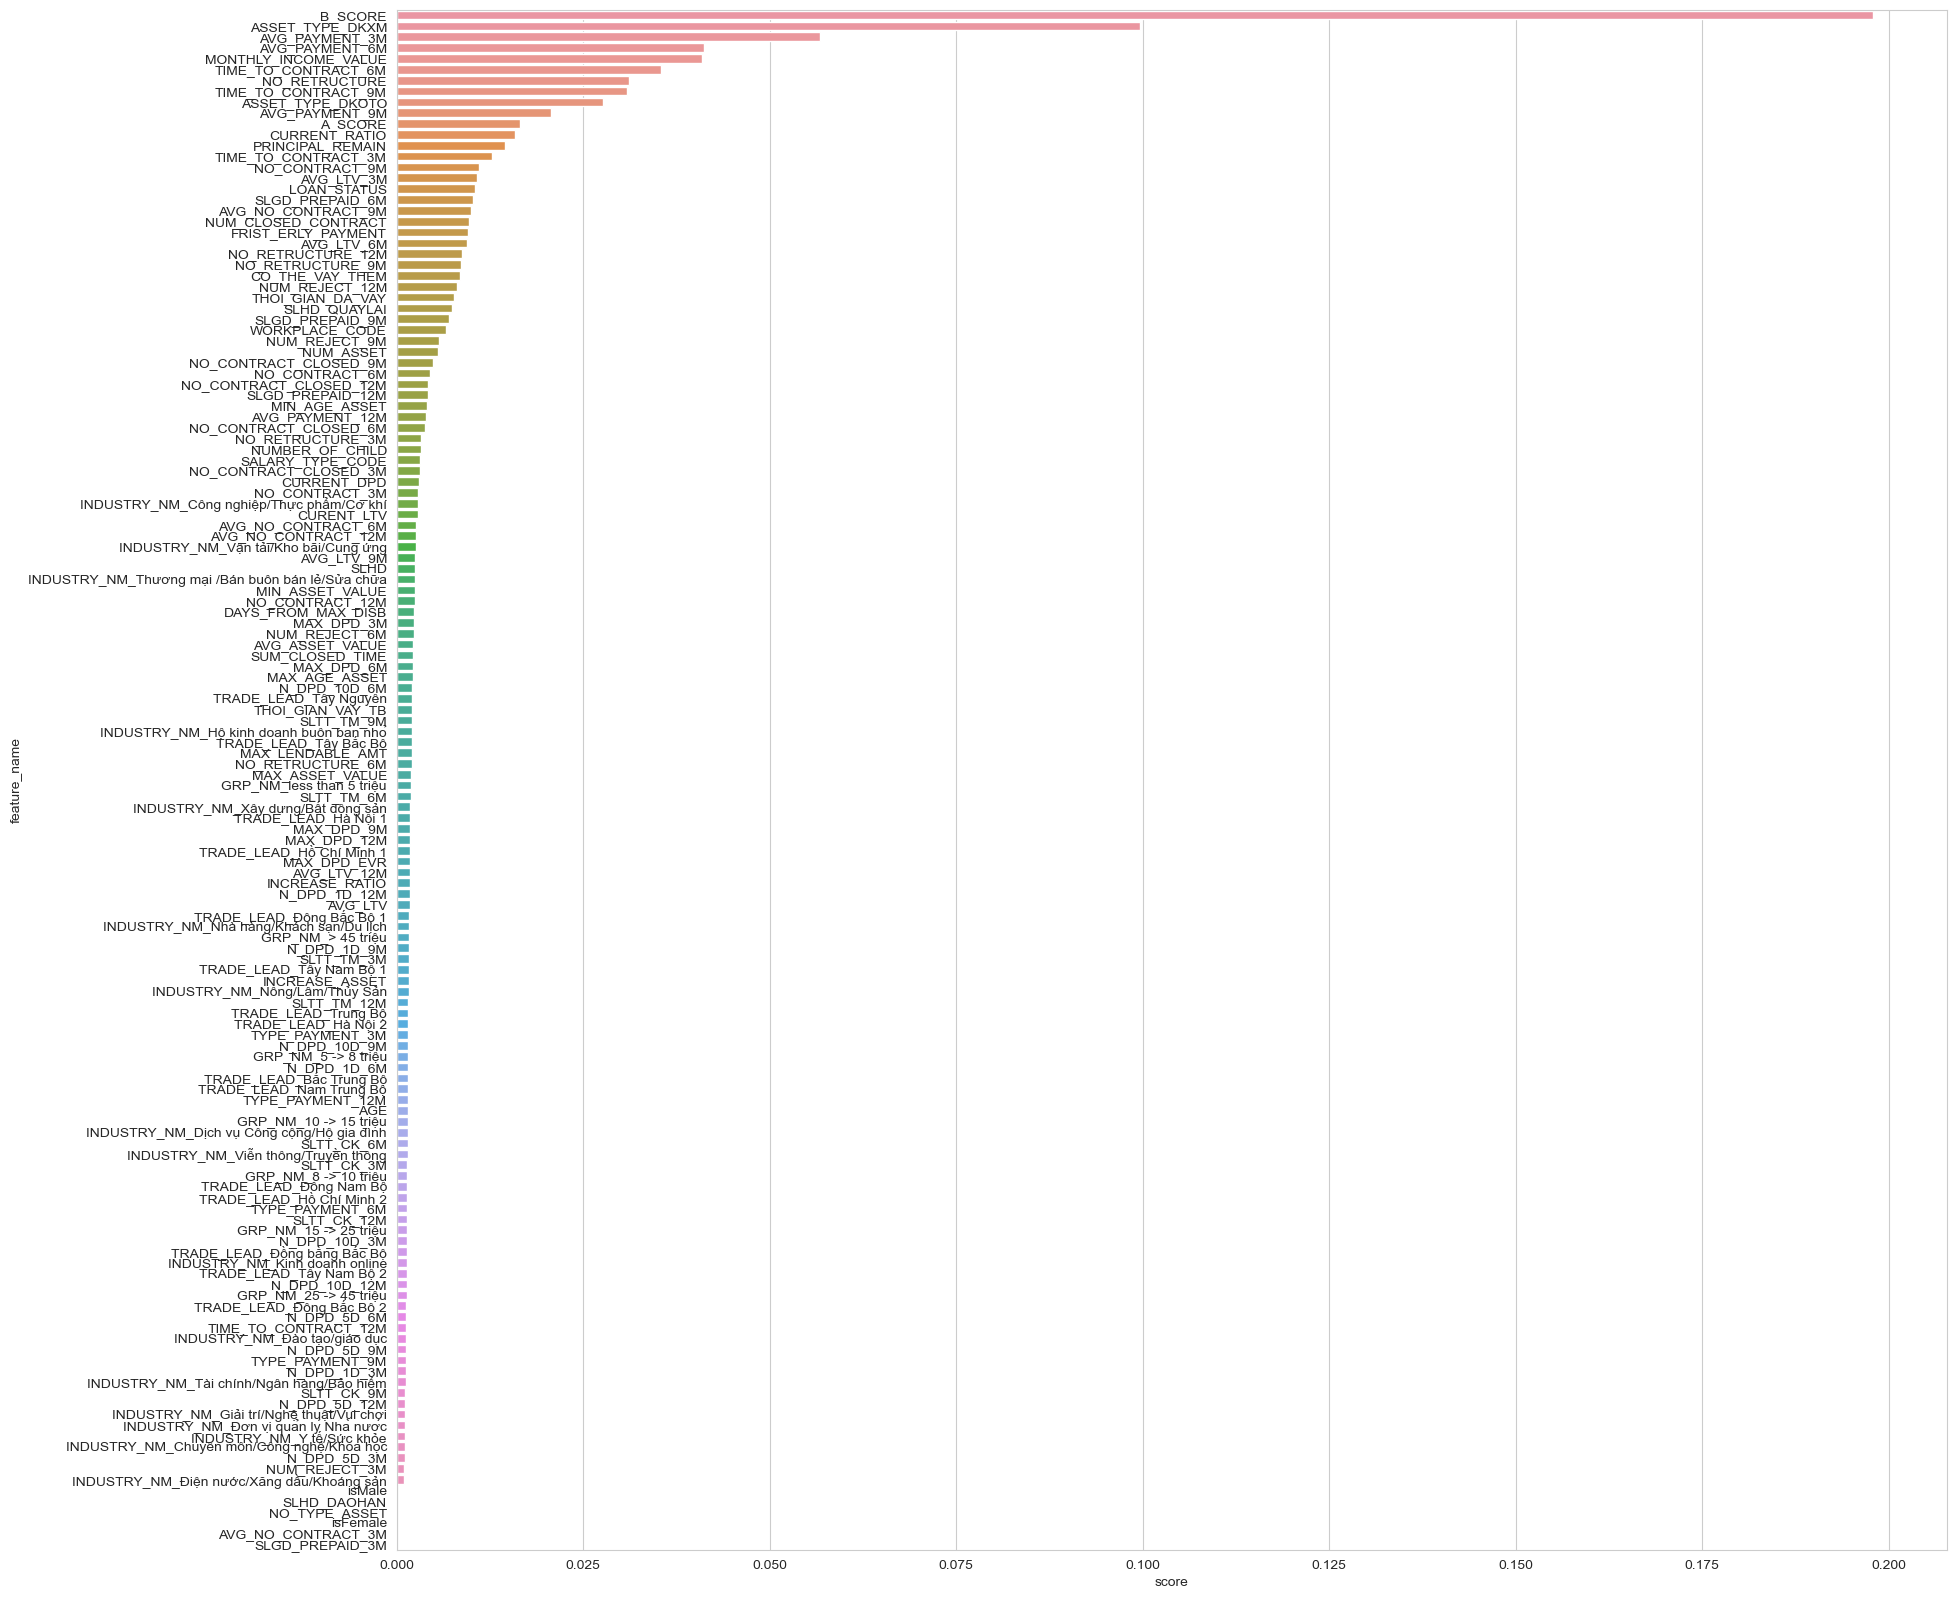

#########################
Fold 4
#########################
[0]	validation_0-logloss:0.67362	validation_1-logloss:0.67366
[100]	validation_0-logloss:0.49314	validation_1-logloss:0.49583
[200]	validation_0-logloss:0.47978	validation_1-logloss:0.48629
[300]	validation_0-logloss:0.47154	validation_1-logloss:0.48181
[400]	validation_0-logloss:0.46555	validation_1-logloss:0.47914
[500]	validation_0-logloss:0.46014	validation_1-logloss:0.47711
[600]	validation_0-logloss:0.45561	validation_1-logloss:0.47561
[700]	validation_0-logloss:0.45150	validation_1-logloss:0.47448
[800]	validation_0-logloss:0.44762	validation_1-logloss:0.47374
[900]	validation_0-logloss:0.44393	validation_1-logloss:0.47329
[1000]	validation_0-logloss:0.44044	validation_1-logloss:0.47284
[1100]	validation_0-logloss:0.43735	validation_1-logloss:0.47272
[1200]	validation_0-logloss:0.43426	validation_1-logloss:0.47242
[1214]	validation_0-logloss:0.43390	validation_1-logloss:0.47241
best iteration 1164
              precision

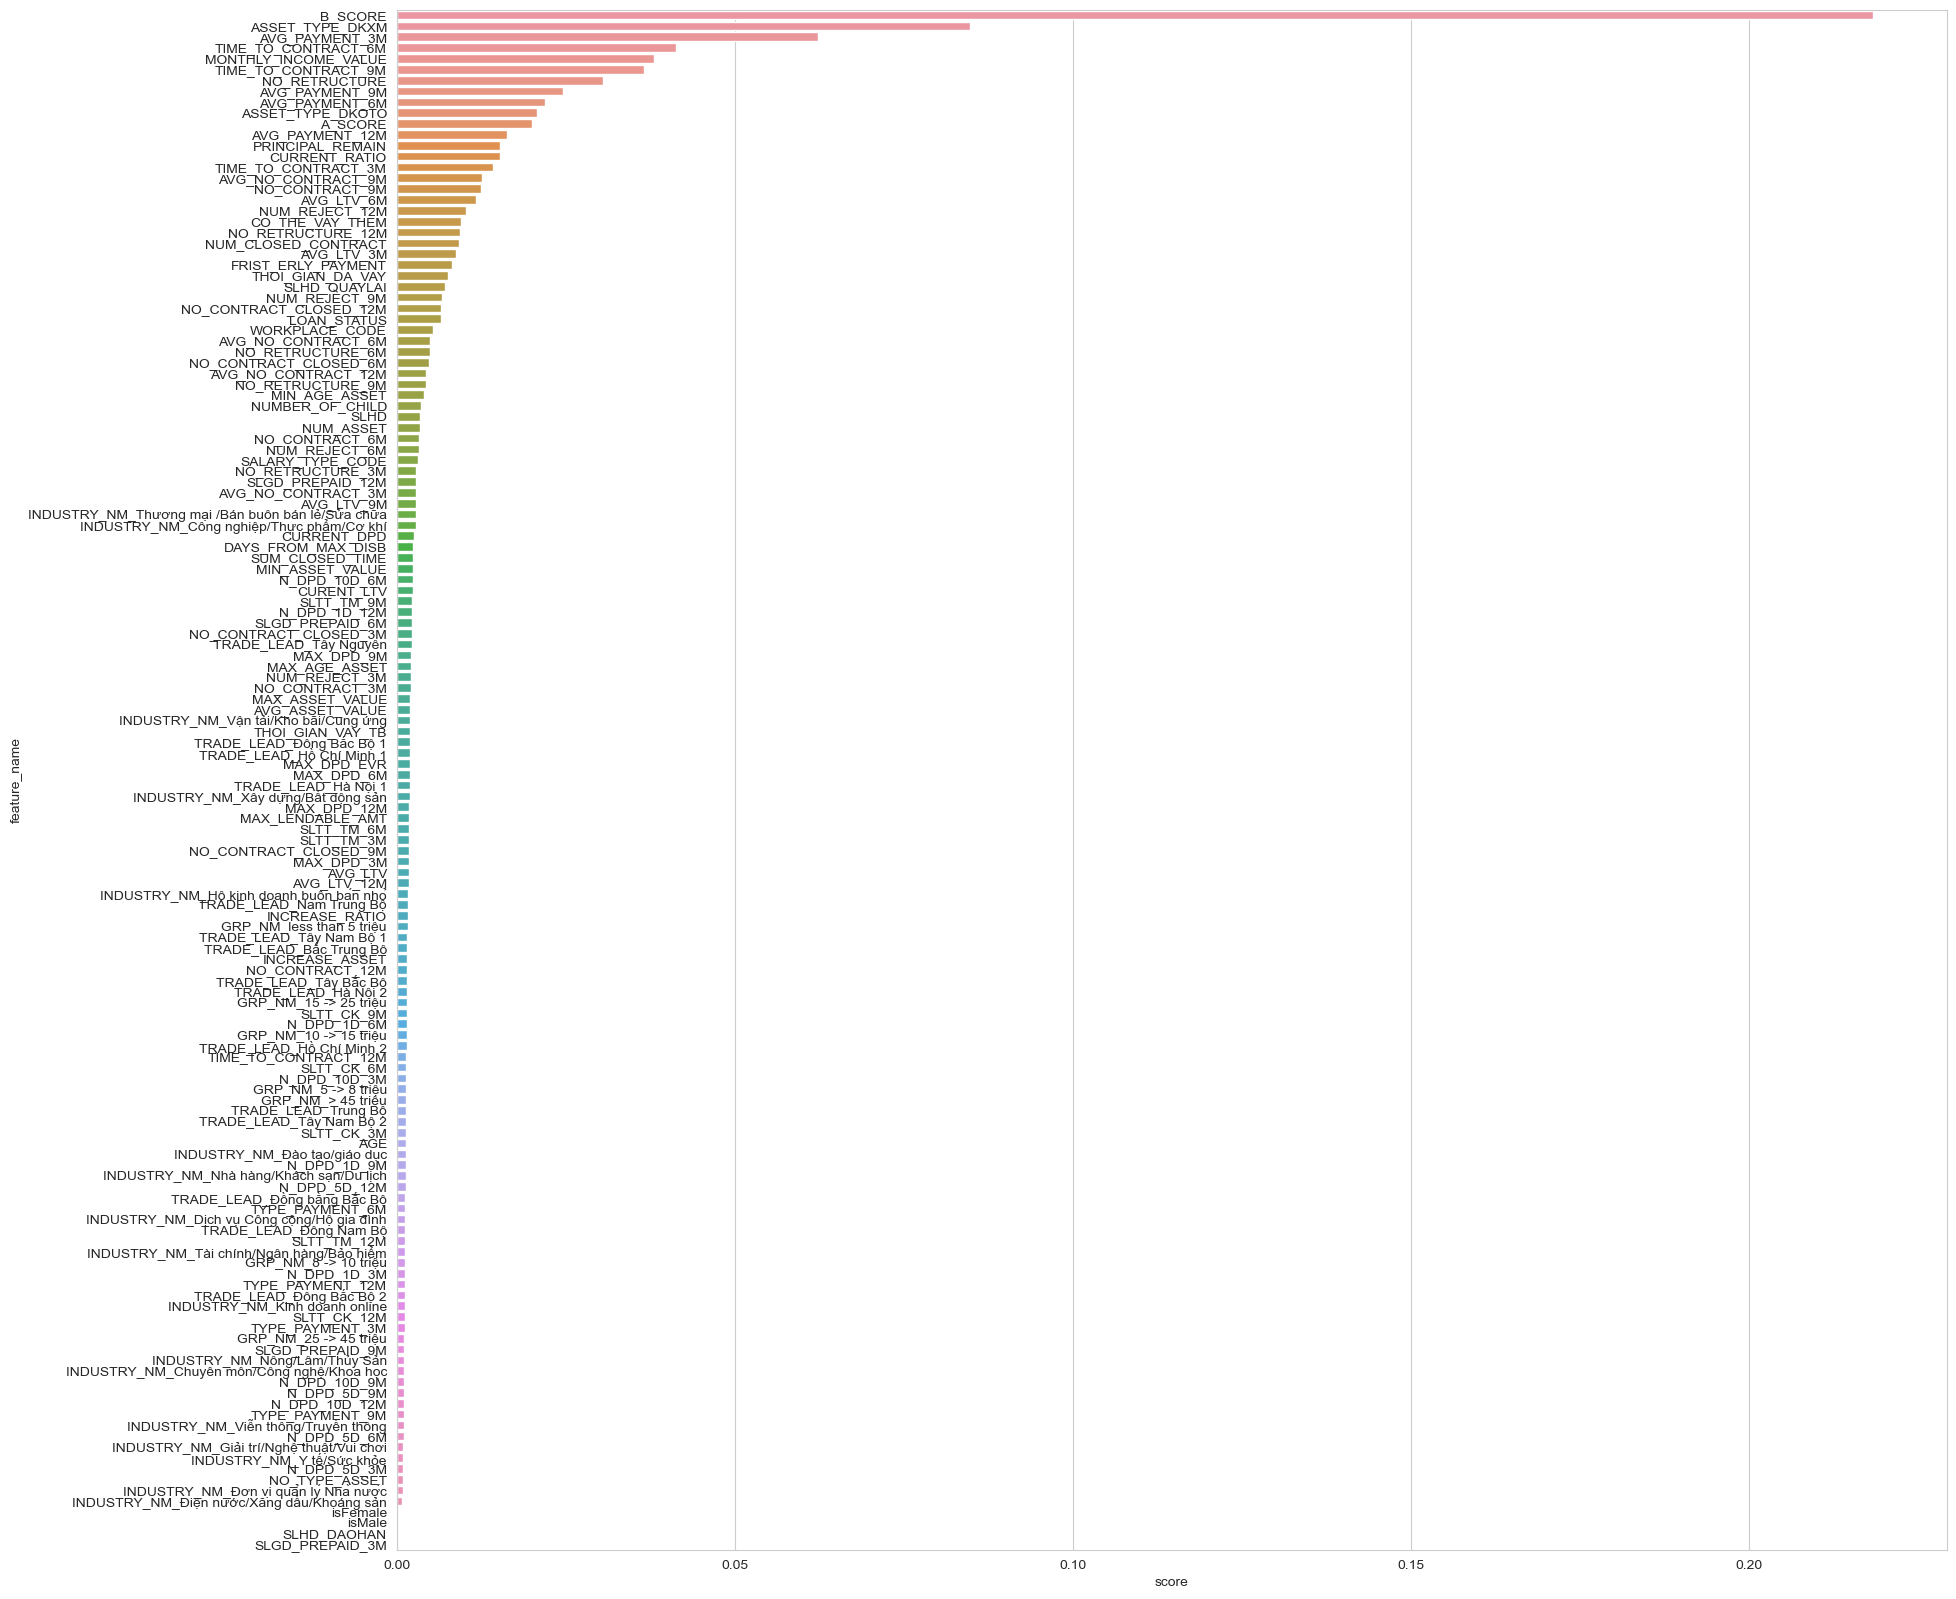

In [28]:
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
fold = GroupKFold(n_splits=5)
groups = train_df.CUSTOMER_CODE_2

oofs = np.zeros(train_df.shape[0])
models = []
best_estimations = []
for i, (train_index, valid_index) in enumerate(fold.split(new_train_df, groups=groups)):
    print("#"*25)
    print("Fold", i)
    print("#"*25)
    X_train = new_train_df.iloc[train_index]
    X_valid = new_train_df.iloc[valid_index]
    y_train = train_labels.iloc[train_index].values
    y_valid = train_labels.iloc[valid_index].values

    xgb_params = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.1,
        'max_depth': 5,
        'n_estimators': 2000,
        'early_stopping_rounds': 50,
        'alpha':8,
        'subsample':0.8,
        'colsample_bytree': 0.8,
        'tree_method': 'gpu_hist',
        'seed':42,
        'use_label_encoder' : False}
    model =  XGBClassifier(**xgb_params)
    model.fit(X_train.astype('float32'), y_train,
            eval_set=[(X_train.astype('float32'), y_train), (X_valid.astype('float32'),y_valid)],
            verbose=100)

    y_pred = model.predict(X_valid)
    y_pred_prob = model.predict_proba(X_valid)[:,1]

    oofs[valid_index] = y_pred_prob
    models.append(model)
    print('best iteration', model.best_iteration)
    best_estimations.append((model.best_iteration))
    print(classification_report(y_valid, y_pred, digits=4))
    print(roc_auc_score(y_valid, y_pred_prob))

    feat_imp = pd.DataFrame({'feature_name': model.feature_names_in_,
                             'score': model.feature_importances_}).sort_values('score',ascending=False)
    plt.figure(figsize=(20,20))
    sns.barplot(x='score', y= 'feature_name', data=feat_imp)
    plt.show()

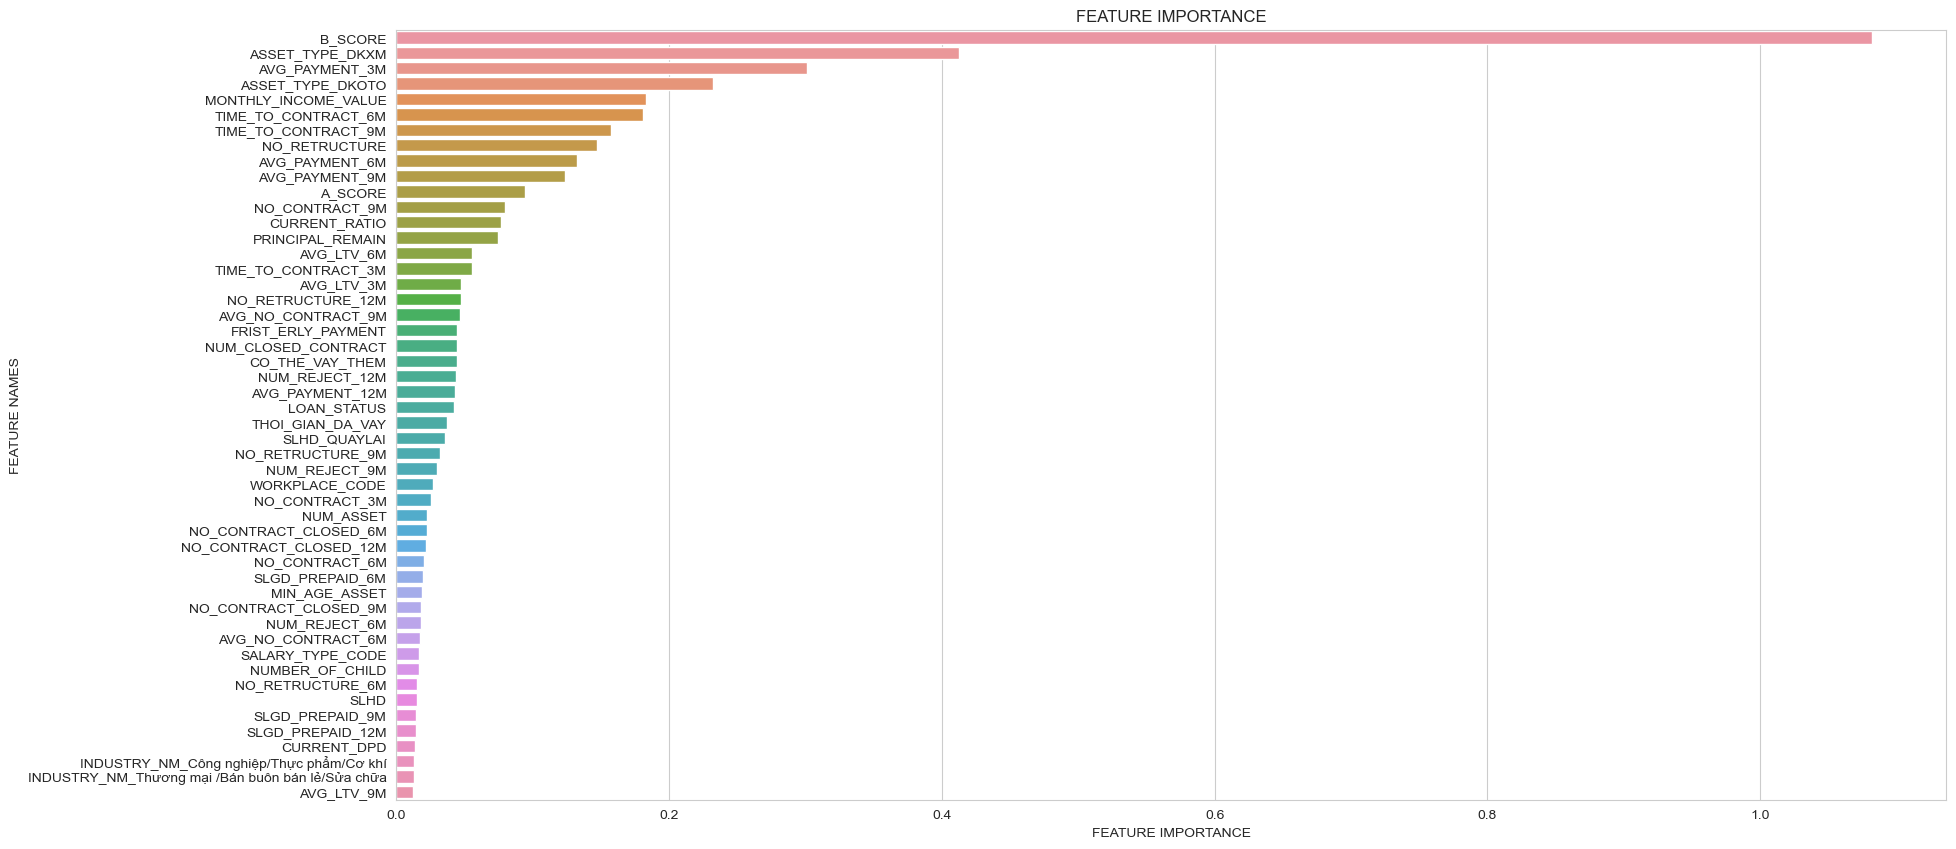

In [29]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.head(50)
    #Define size of bar plot
    plt.figure(figsize=(20,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
feat_imp = {}
for model in models:
    for x, y in zip(model.feature_importances_, model.feature_names_in_):
        if y not in feat_imp:
            feat_imp[y] = x
        else:
            feat_imp[y]+=x
plot_feature_importance(list(feat_imp.values()),list(feat_imp.keys()),'')

In [30]:
from sklearn.metrics import f1_score, accuracy_score
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.3,0.9,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oofs>threshold).astype('int')
    m = accuracy_score(train_labels, preds)
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 

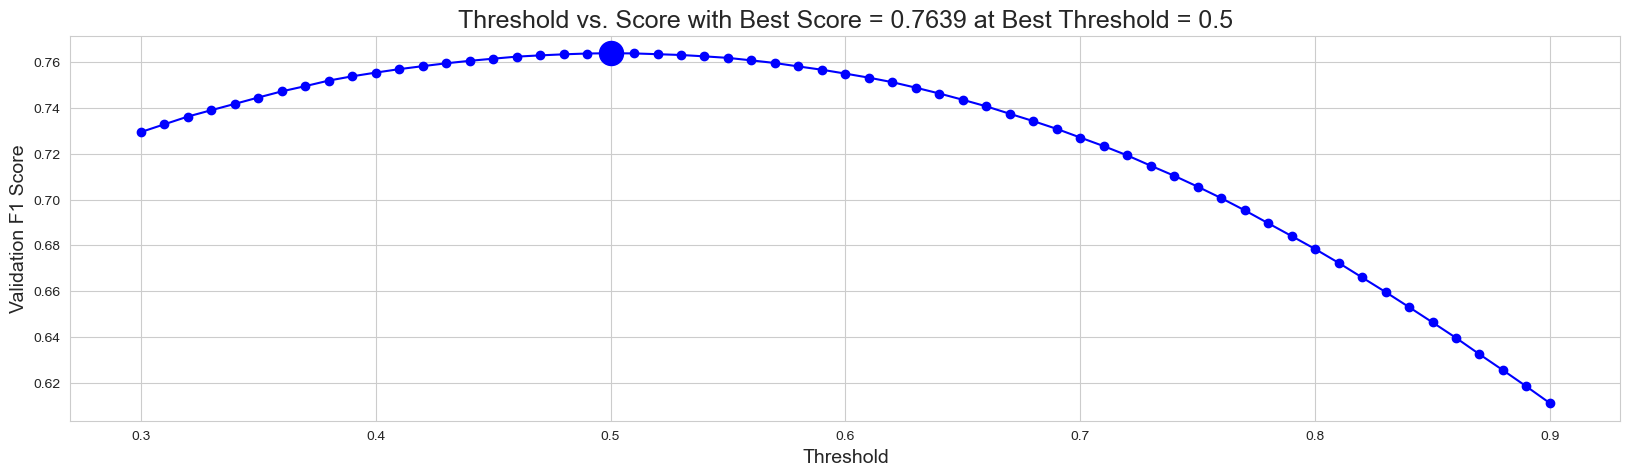

In [31]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. Score with Best Score = {best_score:.4f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

### Train all

In [37]:
xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': max(best_estimations)+1,
    'alpha':8,
    'subsample':0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'gpu_hist',
    'seed':42,
    'use_label_encoder' : False}
g_model = XGBClassifier(**xgb_params)
g_model.fit(new_train_df, train_labels,verbose=100)

XGBClassifier(alpha=8, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1508, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [38]:
g_model

XGBClassifier(alpha=8, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1508, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

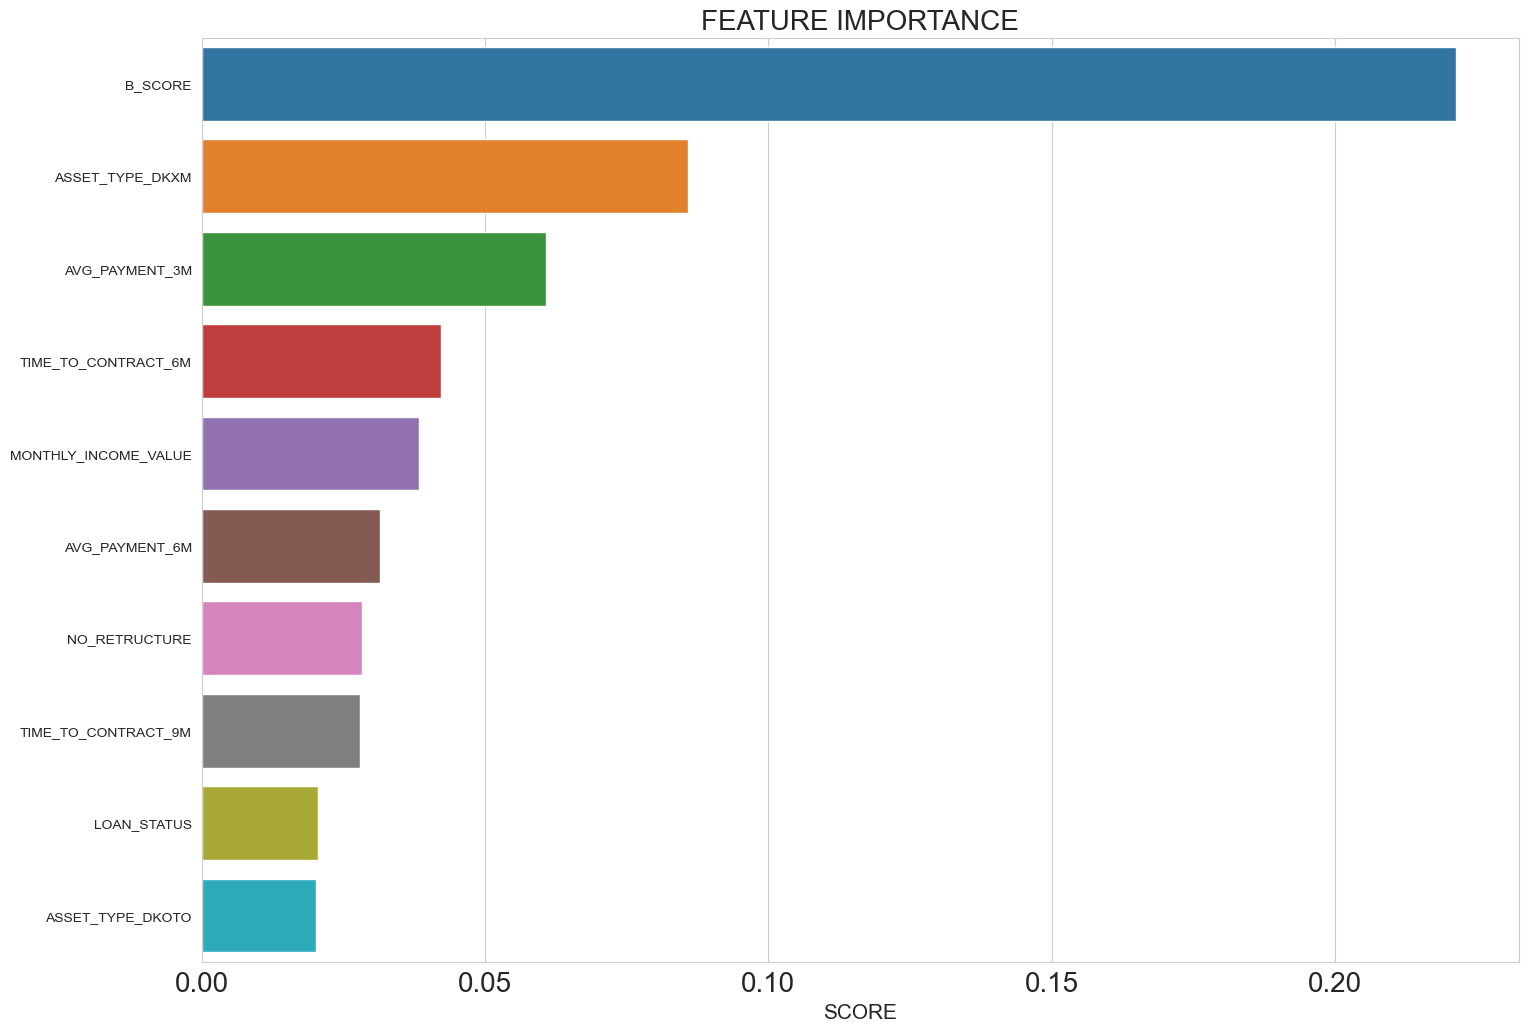

In [39]:
feat_imp = pd.DataFrame({'feature_name': g_model.feature_names_in_,
                         'score': g_model.feature_importances_}).sort_values('score',ascending=False)
plt.figure(figsize=(17,12))
sns.barplot(x='score', y= 'feature_name', data=feat_imp.head(10))
plt.xlabel('SCORE', fontsize=15)
plt.ylabel('')
plt.title("FEATURE IMPORTANCE", fontsize=20)
plt.xticks(fontsize=20)
# labels = ['Tuổi', 'Giá trị TSDB thấp nhất', 'Giá trị TSDB trung bình', 'Số tiền được vay tối đa', 'Có thể vay thêm', 'Dư nợ','Thời gian đã vay', 'LTV khoan vay hiện tại','Giá trị TSDB cao nhất','Trung bình LTV']
# labels = ['Số tiền được vay tối đa','Giá trị TSDB thấp nhất','Giá trị TSDB trung bình','Tuổi','Trung bình LTV','Dư nợ', 'LTV hiện tại','Có thể vay thêm','Giá trị TSDB cao nhất', 'Trung bình LTV 12 tháng' ]
# plt.yticks(ticks=[int(i) for i in range(10)], labels=labels,fontsize=20)

plt.show()

## Predict

### CV predict

In [40]:
y_pred_prob = np.zeros(new_test_df.shape[0])
for model in models:
    y_pred_prob+=model.predict_proba(new_test_df)[:,1]/5

In [41]:
y_preds = y_pred_prob>0.5
print(classification_report(test_labels, y_preds, digits=4))

              precision    recall  f1-score   support

           0     0.7582    0.7404    0.7492     85384
           1     0.7670    0.7835    0.7752     93135

    accuracy                         0.7629    178519
   macro avg     0.7626    0.7620    0.7622    178519
weighted avg     0.7628    0.7629    0.7627    178519



In [42]:
from sklearn.metrics import accuracy_score, average_precision_score
print(accuracy_score(test_labels, y_preds))

0.7628935855567195


### All predict

In [43]:
for model in models:
    y_pred_prob = g_model.predict_proba(new_test_df)[:,1]

In [44]:
y_preds = y_pred_prob>0.5
print(classification_report(test_labels, y_preds, digits=4))

              precision    recall  f1-score   support

           0     0.7572    0.7428    0.7500     85384
           1     0.7683    0.7817    0.7749     93135

    accuracy                         0.7631    178519
   macro avg     0.7628    0.7622    0.7624    178519
weighted avg     0.7630    0.7631    0.7630    178519



In [45]:
from sklearn.metrics import accuracy_score, average_precision_score
print(accuracy_score(test_labels, y_preds))

0.7630896431192198


In [ ]:
# PRINCIPAL_REMAIN = sorted(new_train_df['PRINCIPAL_REMAIN'].unique())
# PRINCIPAL_REMAINS = np.linspace(0, 3*10**7,200)
# principal_remains_matrix = np.zeros((new_train_df.shape[0],len(PRINCIPAL_REMAINS)))
# new_train_copy = new_train_df.copy()
# for i in tqdm(range(len(PRINCIPAL_REMAINS))):
#     new_train_copy['PRINCIPAL_REMAIN'] = PRINCIPAL_REMAINS[i]
#     principal_remains_matrix[:,i] += g_model.predict_proba(new_train_copy)[:,1]

In [ ]:
# plt.figure(figsize=(17, 10))
# y = np.mean(principal_remains_matrix,axis=0)
# y_std = np.std(principal_remains_matrix, axis=0)
# ax = sns.lineplot(x=PRINCIPAL_REMAINS,y=y, linewidth=2)
# plt.xlabel('PRINCIPAL_REMAINS')
# plt.ylabel('UPSELL_PROBA')
# plt.title("PARTIAL DEPENDENCY PLOT")

In [75]:
# THOI_GIAN_DA_VAY = np.linspace(58, 380,200)
# THOI_GIAN_DA_VAY_matrix = np.zeros((new_train_df.shape[0],len(THOI_GIAN_DA_VAY)))
# new_train_copy = new_train_df.copy()
# for i in tqdm(range(len(THOI_GIAN_DA_VAY))):
#     new_train_copy['THOI_GIAN_DA_VAY'] = THOI_GIAN_DA_VAY[i]
#     THOI_GIAN_DA_VAY_matrix[:,i] += g_model.predict_proba(new_train_copy)[:,1]

 12%|█▏        | 24/200 [05:47<36:19, 12.38s/it]Exception ignored in: <function _InnerPredictor.__del__ at 0x0000017F06A94CA0>
Traceback (most recent call last):
  File "C:\Users\duclh3\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py", line 775, in __del__
    try:
KeyboardInterrupt: 
 17%|█▋        | 34/200 [06:31<31:52, 11.52s/it]


KeyboardInterrupt: 

In [ ]:
# plt.figure(figsize=(17, 10))
# y = np.mean(THOI_GIAN_DA_VAY_matrix,axis=0)
# ax = sns.lineplot(x=THOI_GIAN_DA_VAY,y=y, linewidth=2)
# sns.lineplot(x=THOI_GIAN_DA_VAY,y=0.4, linestyle='dashed', linewidth=1)
# plt.legend(labels=["partial dependency","threshold"])
# plt.xlabel('THOI_GIAN_DA_VAY')
# plt.ylabel('UPSELL_PROBA')
# plt.title("PARTIAL DEPENDENCY PLOT")

<AxesSubplot:xlabel='THOI_GIAN_VAY_TB'>

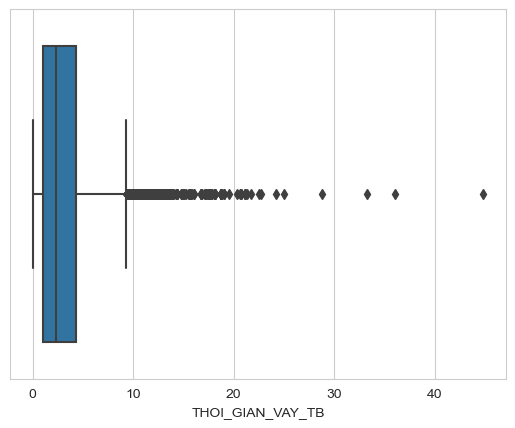

In [68]:
# sns.boxplot(new_train_df[new_train_df['THOI_GIAN_VAY_TB']!= -999]['THOI_GIAN_VAY_TB'])

In [70]:
# THOI_GIAN_VAY_TB = np.linspace(0, 10, 200)
# TTHOI_GIAN_VAY_TB_matrix = np.zeros((new_train_df.shape[0],len(THOI_GIAN_VAY_TB)))
# new_train_copy = new_train_df.copy()
# for i in tqdm(range(len(THOI_GIAN_VAY_TB))):
#     new_train_copy['THOI_GIAN_VAY_TB'] = THOI_GIAN_VAY_TB[i]
#     TTHOI_GIAN_VAY_TB_matrix[:,i] = g_model.predict_proba(new_train_copy)[:,1]

100%|██████████| 200/200 [13:42<00:00,  4.11s/it]


Text(0.5, 1.0, 'PARTIAL DEPENDENCY PLOT')

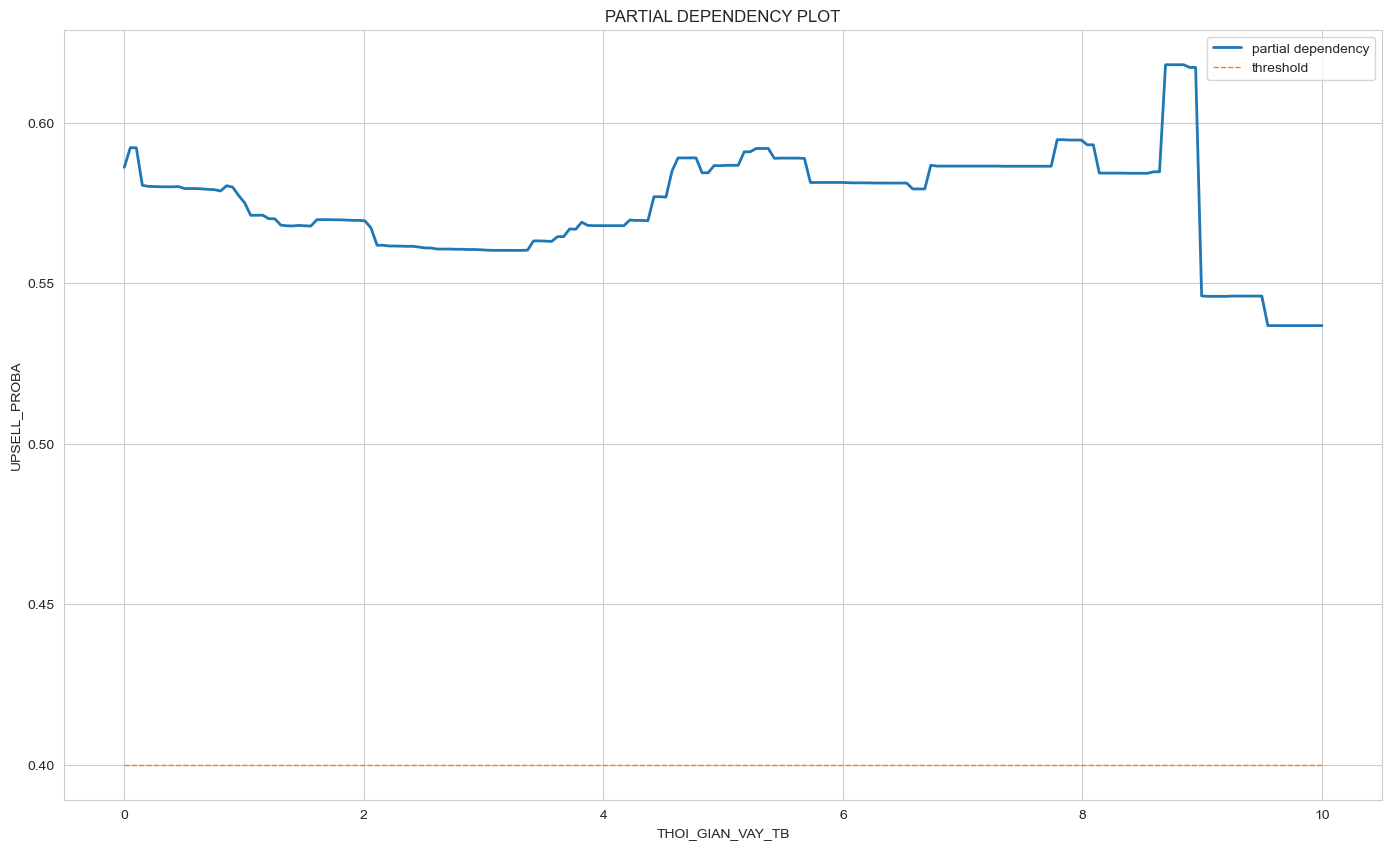

In [71]:
# plt.figure(figsize=(17, 10))
# y = np.mean(TTHOI_GIAN_VAY_TB_matrix,axis=0)
# ax = sns.lineplot(x=THOI_GIAN_VAY_TB,y=y, linewidth=2)
# sns.lineplot(x=THOI_GIAN_VAY_TB,y=0.4, linestyle='dashed', linewidth=1)
# plt.legend(labels=["partial dependency","threshold"])
# plt.xlabel('THOI_GIAN_VAY_TB')
# plt.ylabel('UPSELL_PROBA')
# plt.title("PARTIAL DEPENDENCY PLOT")

## Inference

In [65]:
infer_data = pd.read_csv(CONFIG.INFER_DF)

In [67]:
new_infer_df = feature_engineering(infer_data)
y_pred_prob = np.zeros(new_infer_df.shape[0])
for model in models:
    y_pred_prob+=model.predict_proba(new_infer_df)[:,1]/5

In [68]:
output = pd.DataFrame()
output['CUSTOMER_CODE_2'] = infer_data['CUSTOMER_CODE_2']
output['proba'] = y_pred_prob

In [71]:
output.sort_values('proba', ascending=False, inplace=True)

In [73]:
output.reset_index(inplace=True, drop=True)

In [76]:
output[output.proba>0.48]

CUSTOMER_CODE_2     proba
0             21893475  0.997211
1             21191711  0.996352
2           2225317821  0.996179
3             20323207  0.996174
4             20173637  0.995995
...                ...       ...
11967       2228964686  0.480085
11968         21157001  0.480076
11969         20766580  0.480061
11970     202266428107  0.480036
11971         21732469  0.480010

[11972 rows x 2 columns]

In [77]:
output.to_csv('output.csv',index=False)